## 1. Постановка задачи


В данном проекте я попробую решить задачу прогнозирования индекса РТС, основываясь на новостном фоне.

Индекс РТС — ценовой, взвешенный по рыночной капитализации композитный индекс российского фондового рынка, включающий наиболее ликвидные акции крупнейших российских эмитентов.

Данный проект может показать и отсутствия связи новостного фона с движением данного инструмента, задача  сложная и точно заявить, что задача имеет решение нельзя.

Я соберу свой датасет, коллеги имеют новостную базу данных, которая ежедневно пополняется с 2014 года.

**Основные цели проекта:**
1. Собрать датасет.
2. Сформировать целевую переменную
3. Произвести предобработку набора данных.
4. Провести разведывательный анализ данных и выявить основные закономерности.
5. Построить несколько моделей машинного обучения.
6. Спроектировать процесс предсказания

Начинаем с импорта библиотек

In [7]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import datetime
import numpy
from statistics import mean
import statistics
import nltk
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.decomposition as skd
import numpy as np
from numpy import sqrt 



import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

import spacy
from spacy.lang.ru.examples import sentences 

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
#nltk.download('stopwords')

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

from __future__ import print_function
from collections import defaultdict
from random import randint

from statistics import mean
from scipy.stats import shapiro
from scipy.stats import ttest_ind


2023-11-28 14:16:02.832640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Сбор информации.

Создам список ключевых слов, по которым будем искать новости.

In [2]:
word_dict=['газпром','gazp','сбербанк','sber','sberp','лукойл','лукоил','lkoh','норильский','gmkn',
           'яндекс','yandex','yndx','новатэк','nvtk','татнефт','tatn','роснефт','rosn','сергутнефтегаз','sngs',
           'магнит','mgnt','икс5','x5','five','мтс','mtss','полиметалл','poly','алрос','alrs','северстал','chmf',
           'полюс','plzl','интер','irao','нлмк','nlmk','втб','vtbr','moex','фосагро','phor','транснефт','trnfp', 
           'ммк','magn','ростелеком','rtkm','русал','rual','аэрофлот','aflt','пик','pikk','русгидро','hydr',
           'еэс','fees','афк','afks','лср','lsrg','cbom','юнипро','upro','dsky','lnta','сафмар','sfin',
           'русснефт','rnft','Мвидео','mvid','нефт',' медь',' меди','cupper','никел','nikel','олово','tin','серебро','silver','золото','gold']

Создам функцию для соединения к БД

In [8]:
def create_connection(host_name,user_name,user_pass):
    connection = None
    
    try:
        
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_pass
        )
        
        print("Подключение к базе данных прошло успешно")
    except Error as e:
        
        print(f"Произошла ошибка '{e}'")
    return connection

connection = create_connection("localhost","ev","ev")

Подключение к базе данных прошло успешно


База данных устроенна след. образом: на каждый день есть своя таблица. поэтому для начала надо получить список всех таблиц в БД.

In [9]:
query = f'''select table_name
            from OTHER_DATA.table_index'''

In [10]:
df_list_table = pd.read_sql_query(query, connection)
df_list_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   table_name  3621 non-null   object
dtypes: object(1)
memory usage: 28.4+ KB


In [8]:
df_list_table

,table_name
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
3597,2023-11-06
3598,2023-11-07
3599,2023-11-08
3600,2023-11-09


На момент, когда я собирал новости было 3542 дня. с 1 января 2014 года до 9 сентября 2023 года.

In [106]:
df_list_table = df_list_table.iloc[3012:3540] # 3539 База данных каждый день обновляется.  мы остановимся на 3539 днях.

Данные собирал несколько дней, поэтому пользовался отсечением уже отработанных дней.

In [60]:
where=[]
# Собираем все условия LIKE, которые потом соединим через OR
for item in word_dict:
    where.append("lower(text) LIKE '%" + item + "%'")

в первом варианте работал через оператор LIKE, в дальнейшем отказался от него в пользу более быстрого оператора AGAINST(запросы обрабатывались в 5 раз быстрее).

In [61]:
where2=[]
# Собираем все условия, которые потом соединим через OR AGAINST
for item in word_dict:
    where2.append("" + item + "*")

In [15]:
for i in range(len(df_list_table['table_name'])): #делаем цикл по всем выбранным датам
    query = f'''select id, text, time, source_id 
            from NEWS_DATA.`{df_list_table.iloc[i]['table_name']}`
            WHERE MATCH(text) AGAINST(' '''
    query += ' '.join(where2) 
    query = query + "' IN BOOLEAN MODE);" #формируем итоговый запрос
    df_temp = pd.read_sql_query(query, connection) #отправляем запрос
    df_temp['data_table']= df_list_table.iloc[i]['table_name'] #записываем в столбец date_table дату таблицы, потому что в БД в столбце time - время скачивание без самой даты
    cur_day= df_list_table.iloc[i]['table_name']
    df_temp.to_csv (f'data_diplom1/{cur_day}.csv', index= False )#сохраняем в отдельный файл csv


In [ ]:
# не забываем закрыть соединение после окончания работы
connection.close()

Получили 3539 файлов, общий объем 140Гб! 140 Гб - текстовых файлов!

Оценим кол-во уникальных новостей в сутки. После чего построим график.

In [31]:
main_df = pd.DataFrame()
count_news = []

In [32]:
for i in range(len(df_list_table['table_name'])):
    cur_day=df_list_table.iloc[i]['table_name']
    temp_data = pd.read_csv(f'data_diplom1/{cur_day}.csv',)
    main_df = pd.concat([main_df, temp_data])
    count_news.append(temp_data['text'].nunique())

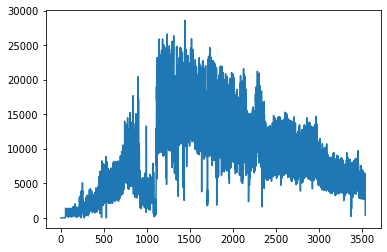

In [54]:
plt.plot(count_news)

По графику можно сделать следующие выводы:
1. Сборщик новостей постоянно дополнялся источниками, отчетливо видно увеличение  количеств новостей в сутки с начала работы данного агрегатора.
2. Наблюдается резкое падение, я спрашивал у создателей о причинах данного провала. Это было связано с маштабным перездом серверов и серьезной переработкой программного кода.
3. После провала наблюдаются максимальные уровни текстов в сутки, но общий тренд падающий. Скорее всего связано с тем, что плохо организована работа, по мониторингу жизни новостных ресурсов(они могут закрываться/"переезжать")
4. Удалю из анализа первые 1100 дней.

Посмотрим на оставшийся "кусок" новостей.

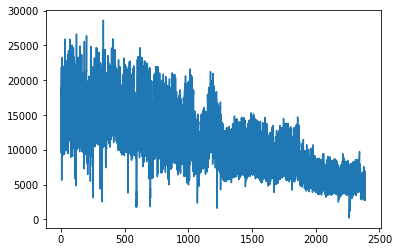

In [74]:
plt.plot(count_news[1110:3500])

Посмотрим на структуру таблицы одного дня.

In [13]:
analiz_day = pd.read_csv(f'data_diplom1/2020-02-05.csv')

In [14]:
analiz_day.head()

,id,text,time,source_id,data_table
0,18,Выставка Фамильное серебро дворянского рода. К...,0 days 10:00:00,30177,2020-02-05
1,84,Баскетбольный матч Зенит - Фенербахче в рамках...,0 days 20:00:00,30177,2020-02-05
2,278,РБК: Голодец перейдет на работу в Сбербанк,0 days 01:32:57,31388,2020-02-05
3,304,Куда поедут туристы на 23 февраля в 2020 году ...,0 days 00:10:00,17539,2020-02-05
4,305,Свыше 40% кают в речных круизах на сезон 2020 ...,0 days 00:10:00,17539,2020-02-05


Имеем: id новости, время когда новость увидели/скачали, источник.

Создам словарь, с помощью которого буду заполнять признаки в основном датасете.

In [469]:
filters = {
    "gaz": ["газпром", "gaz"],
    "sber": ["сбербанк", "sber"],
    "luk": ['лукойл','lkoh'],
    "gmkn": ['норильский','gmkn'],
    "yandex":['яндекс','yandex'],
    "novatek":['новатэк','nvtk'],
    "tatneft":['татнефть','tatn'],
    "rosneft":['роснефть','rosn'],
    "sngs":['сургутнефтегаз','sngs'],
    "magn":['магнит','mgnt'],
    "x5":['икс5','five'],
    "mts":['мтс','mtss'],
    "poly":['полиметалл','poly'],
    "alrosa":['алроса','alrs'],
    "sever":['северсталь','chmf'],
    "polys":['полюс','plzl'],
    "interrao":['интер','irao'],
    "nlmk":['нлмк','nlmk'],
    "vtb":['втб','vtbr'],
    "moex":['ммвб','moex'],
    "phor":['фосагро','phor'],
    "transneft":['транснефть','trnfp'],
    "mmk":['ммк','magn'],
    "rostel":['ростелеком','rtkm'],
    "rusal":['русал','rual'],
    "aero":['аэрофлот','aflt'],
    "pik":['пик','pikk'],
    "rusgydro":['русгидро','hydr'],
    "fees":['еэс','fees'],
    "afk":['афк','afks'],
    "lsr":['лср','lsrg'],
    "mkb":['мкб','cbom'],
    "unipro":['юнипро','upro'],
    "dsky":['детский мир','dsky'],
    "lnta":['лента','lnta'],
    "saf":['сафмар','sfin'],
    "russneft":['русснефть','rnft'],
    "mvideo":['Мвидео','mvid'],
    "oil":['нефть','oil'],
    "cupper":['медь','cupper'],
    "nikel":['никель','nikel'],
    "olovo":['олово','tin'],
    "silver":['серебро','silver'],
    "gold":['золото','gold']
}


Так как русский язык очень сложный в плане огромного количества окончаний. С помощью  библиотеки pymorphy2 проведу очистку текста и переведу все слова к нормальной форме.
Полученный список буду проверять на наличие слов из своего словаря (filters). (1)


In [63]:
'''Стоит обратить внимание, что переменные patterns, stopwords_ru и morph инициализированы
вне функции lemmatize, так как создавать их для каждой записи не имеет смысла — они не изменяются.
Переменная patterns нужна чтобы избавиться от всех некириллических символов и используется в функции
re.sub. Переменная morph – это морфологический анализатор, который используется для нахождения 
нормальной формы слова. Функция lemmatize возвращает список слов (токенов), причем только тех постов,
который содержат более 2 слов.'''

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+" 
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

С помощью библиотеки dostoevsky, буду анализировать каждый текст на тональность. Сразу отмечу тот факт, так как исследовать буду новости, тональность у них на 90+ нейтральна,
но в любом случае будем пытаться "выудить" крупицы тональности.(2)

In [64]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)



Создам отдельный словарь для результатов анализа тональности.

In [65]:
from __future__ import print_function
from collections import defaultdict
from random import randint

In [10]:
dict_values=defaultdict(list)

Создам функцию, на вход которой подаем новость, результатом функции является словарь вида:
{'яндекс': [0.1067005917429924,
              0.051855459809303284,
              0.040855713188648224,
              0.06372499465942383]
   газпром: [0.0396488420665264,.....
После чего оставим среднее значение для каждого признака.

In [11]:
def convert_text(text):
    elem = list(filters.keys())#заберем ключи из словаря
    message=[text]
    for i in elem: # меняем все английские упоминания компаний на русский язык
        text.replace(filters[i][1], filters[i][0]) #потому что лемматизация уберет все англ. слова
    word_list=lemmatize(text) #разбиваем текст на массив слов в нормальной форме
    if word_list:
        for j in elem:
            if filters[j][0] in word_list:
                sentiment2 = model.predict(message, k = 5) #проводим анализ тональности
                dict_values[filters[j][0]].append(sentiment2[0]['positive'])#заполняем словарь


Проведем анализ одного дня.
1. загрузим из файла
2. удалим дубли по колонке текст, часть новостей просто дублируется другими ресурсами без какого-либо изменения текста(перепост)
3. Проведем анализ тональности и посмотрим датасет за один день( должны получить одну строчку)

In [124]:
analiz_day = pd.read_csv(f'data_diplom1/2020-02-05.csv') #загружаем новости
analiz_day=analiz_day.drop_duplicates (subset=['text']) #удаляем дубликаты
dict_values=defaultdict(list) 
new_dict={} #создаем пустой слопарь
for i in range(len(analiz_day)):
    convert_text(analiz_day['text'].iloc[i])#получаем тональность
for key in dict_values:
    print ("%s -> %s" % (key, mean(dict_values[key])))
    new_dict[key]=mean(dict_values[key]) #получаем среднее значение

серебро -> 0.08753148071614474
втб -> 0.07002744746462601
сбербанк -> 0.07865382482144814
яндекс -> 0.05616317232406937
аэрофлот -> 0.06928725904671827
магнит -> 0.06230210128989888
золото -> 0.08599705153979398
сургутнефтегаз -> 0.06284877679177693
мтс -> 0.05698380730528799
полюс -> 0.07194592855456802
нлмк -> 0.07004798170836533
транснефть -> 0.05425924400164597
интер -> 0.0953169041097647
ммвб -> 0.03756363462242815
нефть -> 0.06319866155798404
пик -> 0.07864299195719604
медь -> 0.07861342971254863
русгидро -> 0.07614950729267937
газпром -> 0.04415952192169478
лср -> 0.05989011935889721
ростелеком -> 0.047361566190734325
афк -> 0.0665375789006551
роснефть -> 0.05177987990526473
мкб -> 0.06506895984057337
ммк -> 0.05640019154885695
лента -> 0.08822733919492097
лукойл -> 0.06598277283307996
татнефть -> 0.062075476960412095
никель -> 0.06861949438462034
олово -> 0.057439647789578885
еэс -> 0.04889635435275493
северсталь -> 0.06691499821664322
фосагро -> 0.0714509870029158
полиметалл -

In [125]:
df = pd.DataFrame()
df = pd.DataFrame.from_dict(new_dict, orient='index')
df=df.T
df.head()

,серебро,втб,сбербанк,яндекс,аэрофлот,магнит,золото,сургутнефтегаз,мтс,полюс,...,еэс,северсталь,фосагро,полиметалл,норильский,русснефть,новатэк,сафмар,алроса,юнипро
0,0.087531,0.070027,0.078654,0.056163,0.069287,0.062302,0.085997,0.062849,0.056984,0.071946,...,0.048896,0.066915,0.071451,0.057584,0.082457,0.05779,0.051028,0.069472,0.081227,0.072423


Отличный результат. Теперь необходимо обработать остальные 2400 дней :) . Не забудем только еще добавить столбец с датой.

In [12]:
def analiz (_day):
    analiz_day = pd.read_csv(f'data_diplom1/{_day}.csv') #читаем файл
    analiz_day=analiz_day.drop_duplicates (subset=['text'])#удаляем дубликаты
    for i in range(len(analiz_day)):
        convert_text(analiz_day['text'].iloc[i]) #анализируем тональность
    for key in dict_values:
        #print ("%s -> %s" % (key, mean(dict_values[key])))
        new_dict[key]=mean(dict_values[key])
    df_f = pd.DataFrame.from_dict(new_dict, orient='index')
    df_f=df_f.T
    df_f['date'] = _day
    print(df_f)
    df_f.to_csv (f'dataset_diplom1/{_day}.csv', index= False )#сохраняем в отдельный файл 
    print('Done:',_day)

In [17]:
df_list_table2 = df_list_table.iloc[3537:3540]


In [18]:
df_list_table2

,table_name
3537,2023-09-07
3538,2023-09-08
3539,2023-09-09


Так как обработка текстов заняла практически месяц, массив df_list_table2 менялся каждую сессию.

In [17]:
for i in range(len(df_list_table2['table_name'])):
    df_f = pd.DataFrame()
    cur_day=df_list_table2.iloc[i]['table_name']
    dict_values=defaultdict(list)
    new_dict={}
    analiz(cur_day)

       пик  газпром      медь    никель     лента   яндекс       афк  \
0  0.10415  0.04671  0.067145  0.082664  0.082863  0.06416  0.057201   

   сбербанк       втб       мтс  ...  полиметалл  норильский  сургутнефтегаз  \
0  0.070704  0.061624  0.054203  ...    0.067579     0.07721        0.062361   

   русгидро  татнефть    юнипро       мкб    алроса  русснефть        date  
0  0.062948  0.058462  0.061371  0.062215  0.081605   0.055867  2018-11-30  

[1 rows x 40 columns]
Done: 2018-11-30
     золото      мтс   газпром    лукойл       еэс  полиметалл      медь  \
0  0.090406  0.05837  0.060744  0.069204  0.043992    0.083726  0.073423   

      олово       лср    никель  ...    алроса      нлмк  русгидро   новатэк  \
0  0.056732  0.066905  0.068532  ...  0.063725  0.125933  0.086795  0.060151   

   норильский  транснефть  русснефть       ммк       мкб        date  
0    0.073471    0.092521   0.098089  0.074479  0.069902  2018-12-01  

[1 rows x 37 columns]
Done: 2018-12-01
    

Соберем все в одну таблицу

In [11]:
df_list_table3 = df_list_table.iloc[1100:3540]

In [12]:
df_list_table3

,table_name
1100,2017-01-05
1101,2017-01-06
1102,2017-01-07
1103,2017-01-08
1104,2017-01-09
...,...
3535,2023-09-05
3536,2023-09-06
3537,2023-09-07
3538,2023-09-08


In [13]:
main_dataset = pd.DataFrame()
for i in range(len(df_list_table3['table_name'])):
    cur_day=df_list_table3.iloc[i]['table_name']
    temp_data = pd.read_csv(f'dataset_diplom1/{cur_day}.csv',)
    main_dataset = pd.concat([main_dataset, temp_data])

In [16]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2440 entries, 0 to 0
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   аэрофлот        2438 non-null   float64
 1   газпром         2438 non-null   float64
 2   транснефть      2397 non-null   float64
 3   никель          2437 non-null   float64
 4   роснефть        2437 non-null   float64
 5   золото          2440 non-null   float64
 6   нефть           2439 non-null   float64
 7   пик             2439 non-null   float64
 8   медь            2439 non-null   float64
 9   магнит          2439 non-null   float64
 10  серебро         2439 non-null   float64
 11  лукойл          2436 non-null   float64
 12  ммвб            2276 non-null   float64
 13  афк             2362 non-null   float64
 14  яндекс          2439 non-null   float64
 15  полюс           2438 non-null   float64
 16  втб             2439 non-null   float64
 17  сбербанк        2439 non-null   float64
 

Можно сказать, что датасет на данную момент готов.

## 2. Сформирую целевую переменную

Загрузим котировки индекса РТС

In [14]:
rts_data = pd.read_csv(f'data_diplom1/rts_archive.csv',delimiter=';')

In [15]:
rts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TRADEDATE  1679 non-null   object
 1   CLOSE      1679 non-null   object
 2   OPEN       1679 non-null   object
 3   HIGH       1679 non-null   object
 4   LOW        1679 non-null   object
dtypes: object(5)
memory usage: 65.7+ KB


Посмотрим какие данные есть по индексу РТС в архиве.

In [19]:
rts_data.head()

,TRADEDATE,CLOSE,OPEN,HIGH,LOW
0,05.01.2017,"1180,31","1180,43","1191,26","1172,8"
1,06.01.2017,"1172,59","1177,12","1179,94","1165,42"
2,09.01.2017,"1160,27","1172,12","1176,14","1158,59"
3,10.01.2017,"1175,01","1158,56","1175,91","1155,75"
4,11.01.2017,"1155,5","1169,54","1174,09","1151,54"


TRADEDATE - дата торгов  
CLOSE - цена при окончании торгов  
OPEN - цена при начале торгов  
HIGH - максимальная цена сделки за день  
LOW - минимальная цена сделки за день

Преобразуем дату в тип datetime 

In [16]:
rts_data['date']=pd.to_datetime(rts_data['TRADEDATE'],format='%d.%m.%Y')

In [17]:
rts_data.head()

,TRADEDATE,CLOSE,OPEN,HIGH,LOW,date
0,05.01.2017,"1180,31","1180,43","1191,26","1172,8",2017-01-05
1,06.01.2017,"1172,59","1177,12","1179,94","1165,42",2017-01-06
2,09.01.2017,"1160,27","1172,12","1176,14","1158,59",2017-01-09
3,10.01.2017,"1175,01","1158,56","1175,91","1155,75",2017-01-10
4,11.01.2017,"1155,5","1169,54","1174,09","1151,54",2017-01-11


Так же преобразуем в в основном датасете столбец date в тип datetime

In [18]:
main_dataset['date']=pd.to_datetime(main_dataset['date'],format='%Y-%m-%d')

Добавим дельту за день (изменение стоимости индекса).

In [19]:
rts_data['CLOSE'] = rts_data['CLOSE'].str.replace(',', '.')
rts_data['CLOSE'] = rts_data['CLOSE'].astype(float)
rts_data['OPEN'] = rts_data['OPEN'].str.replace(',', '.')
rts_data['OPEN'] = rts_data['OPEN'].astype(float)
rts_data['HIGH'] = rts_data['HIGH'].str.replace(',', '.')
rts_data['HIGH'] = rts_data['HIGH'].astype(float)
rts_data['LOW'] = rts_data['LOW'].str.replace(',', '.')
rts_data['LOW'] = rts_data['LOW'].astype(float)

Расчитаем суточное изменение индекса РТС

In [20]:
rts_data['delta']=(rts_data['CLOSE'] * 100 / rts_data['OPEN'] ) - 100

In [21]:
rts_data.head()

,TRADEDATE,CLOSE,OPEN,HIGH,LOW,date,delta
0,05.01.2017,1180.31,1180.43,1191.26,1172.80,2017-01-05,-0.010166
1,06.01.2017,1172.59,1177.12,1179.94,1165.42,2017-01-06,-0.384838
2,09.01.2017,1160.27,1172.12,1176.14,1158.59,2017-01-09,-1.010989
3,10.01.2017,1175.01,1158.56,1175.91,1155.75,2017-01-10,1.419866
4,11.01.2017,1155.50,1169.54,1174.09,1151.54,2017-01-11,-1.200472


Удалим  из таблицы rts_data все столбцы кроме даты и дельты.

In [22]:
rts_data = rts_data.drop(columns = ['TRADEDATE', 'CLOSE','OPEN','HIGH','LOW'], axis = 1) 

Объеденим две таблицы в главный датафрейм.

In [23]:
final_df = pd.merge(main_dataset,rts_data,how='outer',on='date')

In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   аэрофлот        2438 non-null   float64       
 1   газпром         2438 non-null   float64       
 2   транснефть      2397 non-null   float64       
 3   никель          2437 non-null   float64       
 4   роснефть        2437 non-null   float64       
 5   золото          2440 non-null   float64       
 6   нефть           2439 non-null   float64       
 7   пик             2439 non-null   float64       
 8   медь            2439 non-null   float64       
 9   магнит          2439 non-null   float64       
 10  серебро         2439 non-null   float64       
 11  лукойл          2436 non-null   float64       
 12  ммвб            2276 non-null   float64       
 13  афк             2362 non-null   float64       
 14  яндекс          2439 non-null   float64       
 15  полю

In [25]:
final_df.head()

,аэрофлот,газпром,транснефть,никель,роснефть,золото,нефть,пик,медь,магнит,...,фосагро,алроса,олово,полиметалл,нлмк,русснефть,лср,юнипро,сафмар,delta
0,0.078650,0.045457,0.060691,0.110576,0.063200,0.090848,0.052864,0.111272,0.059262,0.046176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010166
1,0.043376,0.044650,0.044709,0.130198,0.069976,0.104155,0.069006,0.100705,0.095016,0.125233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.384838
2,0.085109,0.049828,NaN,0.119213,NaN,0.111168,0.069096,0.101664,0.082707,0.073735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.098736,0.052170,NaN,NaN,0.091360,0.097291,0.072119,0.121025,0.106701,0.127165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.092965,0.068944,0.054627,0.063939,0.055293,0.112924,0.068186,0.098299,0.087416,0.067640,...,0.095359,0.072654,0.063725,0.071601,0.127673,NaN,NaN,NaN,NaN,-1.010989


Получил полный датасет с признаками и целевой переменной.

## 3. Произведем предобработку набора данных.

В выходные дни торги не проводятся, поэтому значений delta в такие дни не будет, удалим все строчки, которые относятся к выходным дням

In [26]:
final_df = final_df.dropna (subset=['delta'])

Посмотрим процент пропусков по столбцам

In [27]:
final_df.isnull().sum ()/ len(final_df)*100

аэрофлот           0.595238
газпром            0.595238
транснефть         0.773810
никель             0.595238
роснефть           0.595238
золото             0.595238
нефть              0.595238
пик                0.595238
медь               0.595238
магнит             0.595238
серебро            0.595238
лукойл             0.654762
ммвб               0.773810
афк                1.011905
яндекс             0.595238
полюс              0.595238
втб                0.595238
сбербанк           0.595238
северсталь         0.654762
лента              0.595238
мтс                0.654762
сургутнефтегаз     1.250000
русгидро           0.773810
date               0.000000
интер              0.773810
еэс                1.488095
норильский         1.130952
ростелеком         0.773810
мкб                3.869048
новатэк            0.773810
ммк                0.952381
татнефть           0.714286
фосагро            1.607143
алроса            16.011905
олово              1.547619
полиметалл         4

Удалим Сафмар, о нем ничего  не пишут

In [28]:
final_df= final_df.drop(columns = ['сафмар'], axis = 1)

In [33]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1680 entries, 0 to 2449
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   аэрофлот        1670 non-null   float64       
 1   газпром         1670 non-null   float64       
 2   транснефть      1667 non-null   float64       
 3   никель          1670 non-null   float64       
 4   роснефть        1670 non-null   float64       
 5   золото          1670 non-null   float64       
 6   нефть           1670 non-null   float64       
 7   пик             1670 non-null   float64       
 8   медь            1670 non-null   float64       
 9   магнит          1670 non-null   float64       
 10  серебро         1670 non-null   float64       
 11  лукойл          1669 non-null   float64       
 12  ммвб            1667 non-null   float64       
 13  афк             1663 non-null   float64       
 14  яндекс          1670 non-null   float64       
 15  полюс    

У нас есть дни, когда про какие то компании не было новостей, но заменить на 0 нельзя, потому что это можно интерпретировать, как очень негативную оценку, принимаю решение заменить пропуски медианным значением.

In [29]:
final_df = final_df.fillna(final_df.median ())

In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1680 entries, 0 to 2449
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   аэрофлот        1680 non-null   float64       
 1   газпром         1680 non-null   float64       
 2   транснефть      1680 non-null   float64       
 3   никель          1680 non-null   float64       
 4   роснефть        1680 non-null   float64       
 5   золото          1680 non-null   float64       
 6   нефть           1680 non-null   float64       
 7   пик             1680 non-null   float64       
 8   медь            1680 non-null   float64       
 9   магнит          1680 non-null   float64       
 10  серебро         1680 non-null   float64       
 11  лукойл          1680 non-null   float64       
 12  ммвб            1680 non-null   float64       
 13  афк             1680 non-null   float64       
 14  яндекс          1680 non-null   float64       
 15  полюс    

Категоризируем наше изменение индекса РТС на 2 варианта.

In [31]:
def categorize_delta(delta):
    if delta < 0:
        categ = 0
    if delta >= 0:
        categ = 1
    return categ

## 4. Проведем разведывательный анализ данных.

In [32]:
final_df['delta_category'] = final_df.delta.map(categorize_delta)

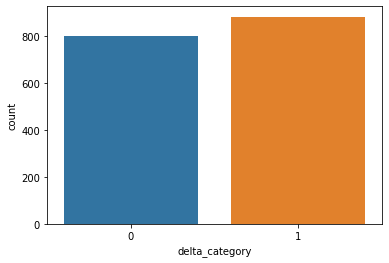

In [33]:
sns.countplot(data=final_df, x='delta_category');

Посмотрим изменение одного(случайного) признака в течении случайного месяца.

In [39]:
from datetime import datetime
deadline1 = datetime(2018, 12, 1)
deadline2 = datetime(2018, 12, 30)

mask = (final_df['date'] < deadline2) & (final_df['date'] > deadline1)

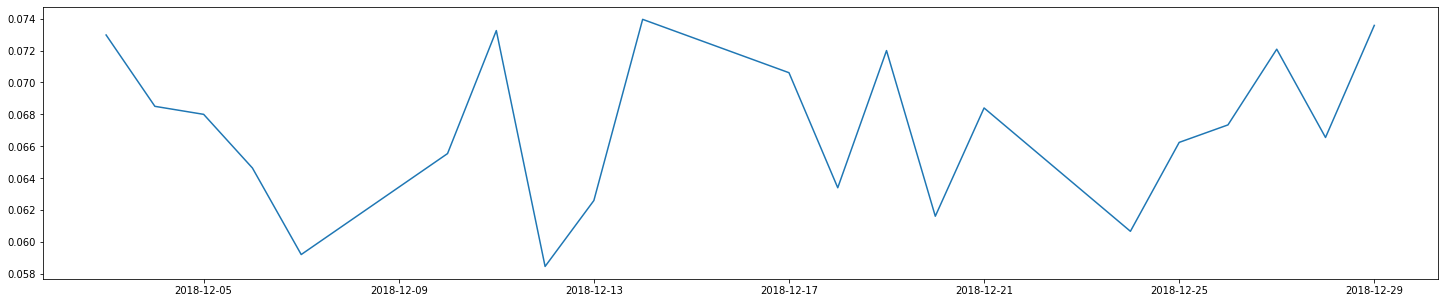

In [40]:
plt.figure(figsize=(25,5))
plt.plot(final_df[mask]['date'], final_df[mask] ['сбербанк'])

Удалим теперь дельту и дату

In [34]:
final_df = final_df.drop(columns = ['delta'], axis = 1)
final_df = final_df.drop(columns = ['date'], axis = 1)

Сохраним медианные значения, чтобы в продакшене заполнять этими значениями пустые данные. Это будет как масштабирование или кодирование признаков: мы как бы "обучаемся" на train-данных, и потом из них всё подставляем/модифицируем для тестовых

In [35]:
X = final_df.drop(['delta_category'], axis=1)
y = final_df['delta_category']

In [36]:
median_value=X.median() #

Построю график  корреляции признаков

<Axes: >

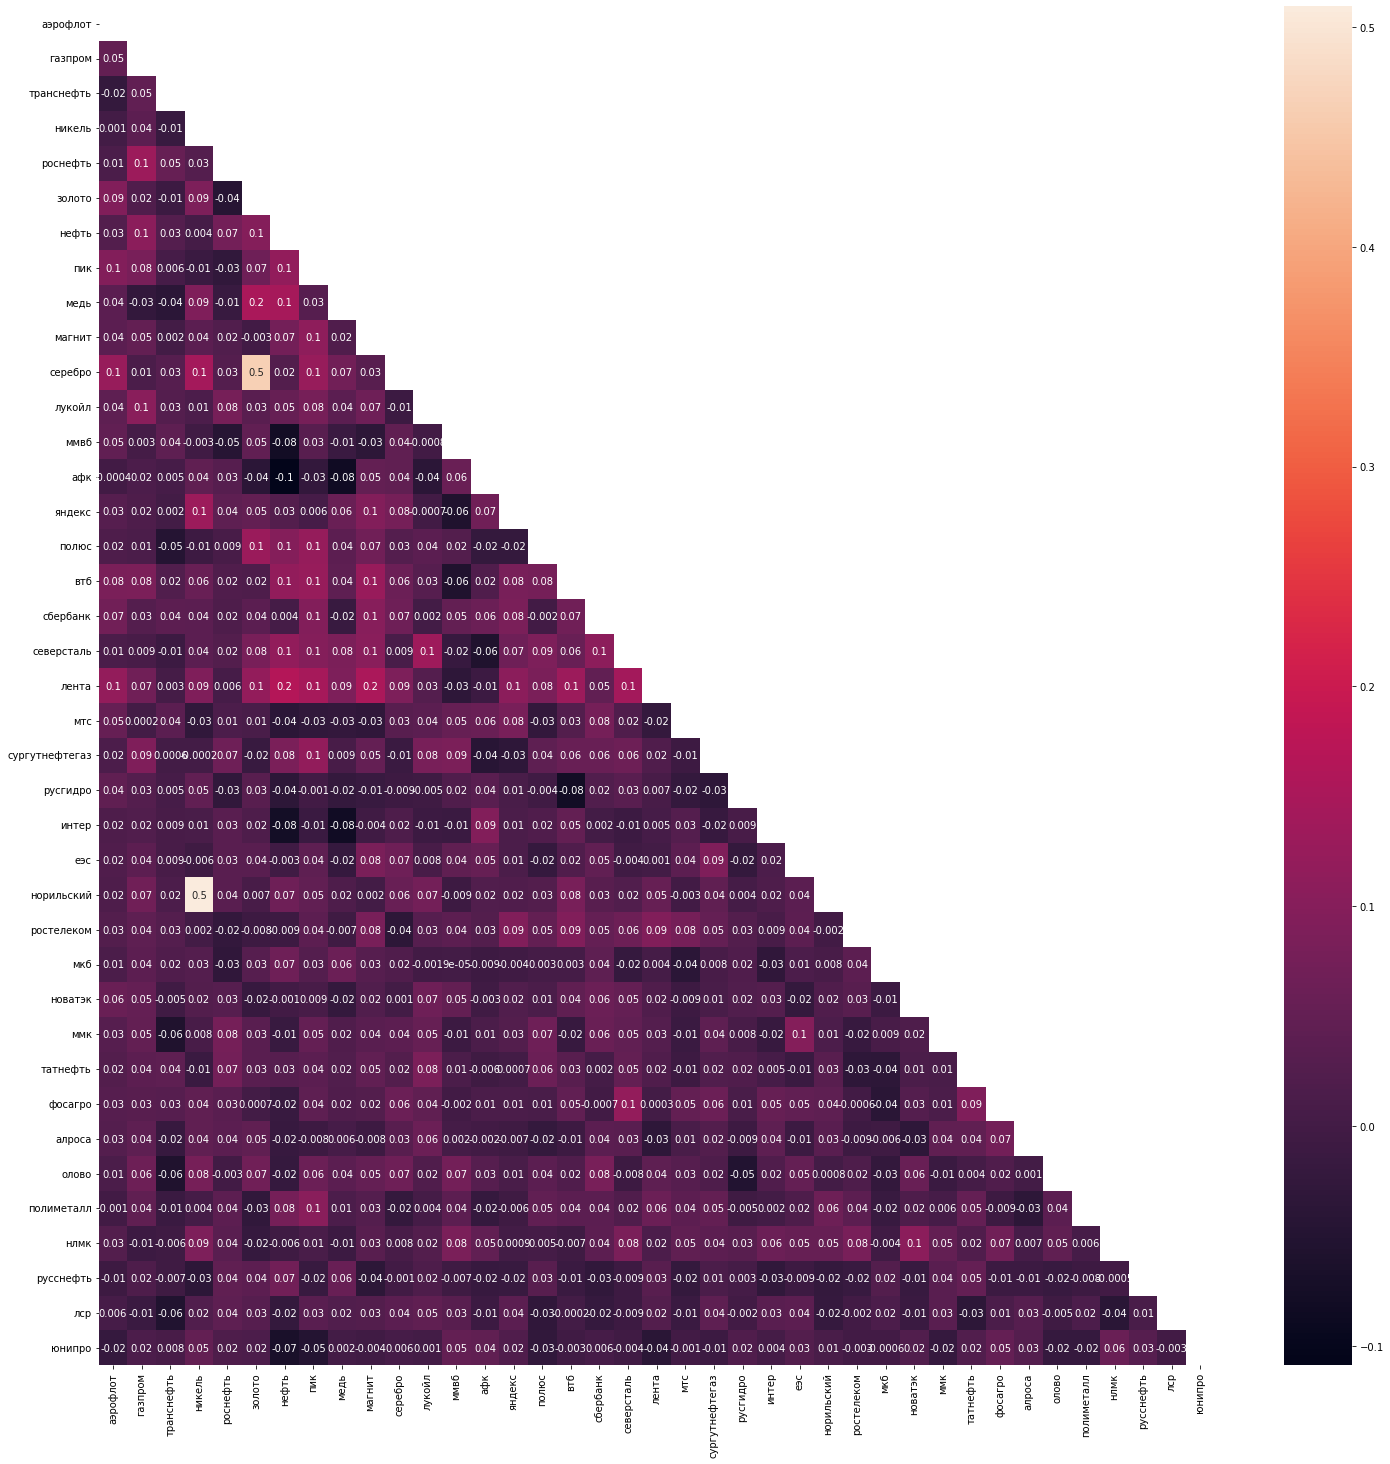

In [43]:
fig, ax = plt.subplots(figsize=(25, 25))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot=True, mask=matrix,fmt='.1g')

Самый высокий коэф. равен 0.5 (и скорее всего они так высоко коррелируются из-за того что компания имеет в названии оба слова :) ) ничего не удаляю.

Проверим выборки на нормальное распределение.

In [44]:
#Установим уровень значимости
alpha = 0.05

In [45]:
_, p = shapiro(final_df['нефть'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print('Данные распределены нормально(Н0)')
else:
	print('Данные НЕ распределены  нормально(отвергаем Н0)')

p=0.000
Данные НЕ распределены  нормально(отвергаем Н0)


Проверим все признаки на расспределение

In [46]:
list_colum=list(X)

In [47]:
for item in list_colum:
    _, p = shapiro(final_df[item])
    print('p=%.3f' % p)

# Интерпретация 

    if p > alpha:
	    print('Данные ' + item +' распределены нормально(Н0)')
    else:
	    print('Данные '+ item + ' НЕ распределены  нормально(отвергаем Н0)')

p=0.000
Данные аэрофлот НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные газпром НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные транснефть НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные никель НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные роснефть НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные золото НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные нефть НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные пик НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные медь НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные магнит НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные серебро НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные лукойл НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные ммвб НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные афк НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные яндекс НЕ распределены  нормально(отвергаем Н0)
p=0.000
Данные полюс НЕ распределены  нормально(отвергае

Все наши данные не распределены нормально.

Посмотрим на примере одного признака

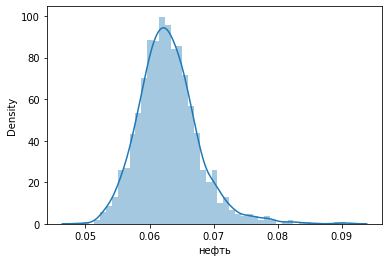

In [48]:
sns_plot = sns.distplot(final_df['нефть'])
fig = sns_plot.get_figure()

Мы имеем больше 3 признаков, группы независимы, признаки не распределены по нормальному закону -> проведем тест Крускала-Уоллиса.

Критерий Крускала-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех или более независимых групп.

Он считается непараметрическим эквивалентом однофакторного дисперсионного анализа .

Тест Крускала-Уоллиса можно провести, используя функцию kruskal() из библиотеки scipy.stats

Нулевая гипотеза (H 0 ): Медиана одинакова для всех групп.

Альтернативная гипотеза: (Ha): Медиана не одинакова для всех групп.

In [49]:
from scipy import stats

#perform Kruskal-Wallis Test 
stats.kruskal(final_df['аэрофлот'],final_df['газпром'], final_df['транснефть'],final_df['никель'], \
    final_df['роснефть'],final_df['золото'],final_df['нефть'],final_df['пик'],final_df['медь'], \
    final_df['магнит'],final_df['серебро'],final_df['лукойл'],final_df['ммвб'],final_df['афк'], \
    final_df['яндекс'],final_df['полюс'],final_df['втб'],final_df['сбербанк'],final_df['северсталь'], \
    final_df['лента'],final_df['мтс'],final_df['сургутнефтегаз'],final_df['русгидро'],final_df['интер'], \
    final_df['еэс'],final_df['норильский'],final_df['ростелеком'],final_df['мкб'],final_df['новатэк'], \
    final_df['ммк'],final_df['татнефть'],final_df['фосагро'],final_df['алроса'],final_df['олово'], \
    final_df['полиметалл'],final_df['нлмк'],final_df['русснефть'],final_df['лср'],final_df['юнипро'])

KruskalResult(statistic=27918.784047009274, pvalue=0.0)

Отвергаем нулевую гипотезу.
Медиана не одинакова.


## 5. Построим несколько моделей машинного обучения.

In [50]:
X = final_df.drop(['delta_category'], axis=1)
y = final_df['delta_category']

In [37]:

from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn import preprocessing #предобработка

from sklearn import linear_model #линейные модели

from sklearn import metrics #метрики

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [53]:
X.describe()

,аэрофлот,газпром,транснефть,никель,роснефть,золото,нефть,пик,медь,магнит,...,ммк,татнефть,фосагро,алроса,олово,полиметалл,нлмк,русснефть,лср,юнипро
count,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,...,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000
mean,0.066134,0.050354,0.057699,0.071405,0.063657,0.093395,0.062957,0.080768,0.072072,0.070357,...,0.066938,0.060105,0.061469,0.057443,0.070123,0.067902,0.065266,0.067377,0.065801,0.055234
std,0.012264,0.005339,0.011397,0.010665,0.007894,0.009657,0.004704,0.008180,0.007667,0.009625,...,0.015618,0.012055,0.016826,0.017909,0.017288,0.019263,0.015500,0.029653,0.016045,0.025435
min,0.030892,0.034631,0.015442,0.045045,0.038363,0.067316,0.049578,0.057183,0.036473,0.040033,...,0.025163,0.011612,0.007826,0.001180,0.014967,0.007587,0.021625,0.010663,0.005740,0.000010
25%,0.058357,0.047026,0.050195,0.064507,0.058292,0.087243,0.059969,0.075862,0.067358,0.064452,...,0.056817,0.052532,0.051381,0.048112,0.059624,0.057076,0.055405,0.052846,0.058299,0.043286
50%,0.064861,0.050164,0.056533,0.070070,0.063112,0.092288,0.062581,0.080228,0.071836,0.069429,...,0.064816,0.059004,0.059126,0.056113,0.068817,0.065290,0.062530,0.061223,0.064819,0.051855
75%,0.072465,0.053454,0.063643,0.076623,0.068243,0.098129,0.065493,0.085273,0.076430,0.075318,...,0.074535,0.066550,0.068475,0.063782,0.078951,0.074724,0.071400,0.072937,0.070924,0.062459
max,0.177518,0.089277,0.134069,0.157227,0.102508,0.146376,0.090684,0.147733,0.116996,0.127344,...,0.164082,0.173199,0.174466,0.248009,0.212668,0.212079,0.162939,0.392347,0.222710,0.355785


Попробуем решить задачу простейшим способом - логистической регрессией.

In [54]:
log_reg = linear_model.LogisticRegression(
    multi_class='auto',
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)

#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [55]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       639
           1       0.52      1.00      0.69       705

    accuracy                           0.52      1344
   macro avg       0.26      0.50      0.34      1344
weighted avg       0.28      0.52      0.36      1344

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.52      1.00      0.69       176

    accuracy                           0.52       336
   macro avg       0.26      0.50      0.34       336
weighted avg       0.27      0.52      0.36       336



Решение задачи классификации методом решающие деревья.

In [41]:
from sklearn import tree 
from sklearn import ensemble 

In [57]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train, y_train)

y_train_pred=dt.predict(X_train)
y_test_pred=dt.predict(X_test)

print(f'Accuracy score for train:{round(metrics.accuracy_score(y_train_pred,y_train),2)}')
print(f'Accuracy score for test:{round(metrics.accuracy_score(y_test_pred,y_test),2)}')

Accuracy score for train:0.66
Accuracy score for test:0.51


Запустим подбор параметров с помощью gridsearch. 

In [58]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2,3,4,5,6,7,8,9,10],
               'max_depth':[3,4,5,6,7,8,9,10],
               'criterion':['gini','entropy','log_loss'],
               'splitter':['best','random'],
               'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=5, scoring=('f1'),
                        return_train_score=True)

model_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='f1')

In [59]:

print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 8, 'splitter': 'random'}


In [60]:
# обучите решающие деревья
dt = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth = 3,
    min_samples_split = 8,
    min_samples_leaf= 2,
    splitter = 'random'
)

dt.fit(X_train, y_train)

y_train_pred=dt.predict(X_train)
y_test_pred=dt.predict(X_test)

print(f'Accuracy score for train:{round(metrics.accuracy_score(y_train_pred,y_train),2)}')
print(f'Accuracy score for test:{round(metrics.accuracy_score(y_test_pred,y_test),2)}')

Accuracy score for train:0.55
Accuracy score for test:0.51


In [61]:
y_train_pred = dt.predict(X_train)

print(metrics.classification_report(y_train, y_train_pred))



              precision    recall  f1-score   support

           0       0.53      0.49      0.51       639
           1       0.57      0.60      0.58       705

    accuracy                           0.55      1344
   macro avg       0.55      0.55      0.55      1344
weighted avg       0.55      0.55      0.55      1344



In [62]:
y_test_pred = dt.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.47      0.48       160
           1       0.53      0.55      0.54       176

    accuracy                           0.51       336
   macro avg       0.51      0.51      0.51       336
weighted avg       0.51      0.51      0.51       336



Проверка работы Наивного байесовского классификатора

In [39]:
from sklearn.naive_bayes import GaussianNB

In [64]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [65]:
y_train_pred=clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [66]:
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56       639
           1       0.59      0.58      0.58       705

    accuracy                           0.57      1344
   macro avg       0.57      0.57      0.57      1344
weighted avg       0.57      0.57      0.57      1344



In [67]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       160
           1       0.54      0.48      0.51       176

    accuracy                           0.52       336
   macro avg       0.52      0.52      0.52       336
weighted avg       0.52      0.52      0.52       336



## Бэггинг: случайный лес. 


In [42]:
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=4, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.20      0.28       160
           1       0.52      0.80      0.63       176

    accuracy                           0.51       336
   macro avg       0.50      0.50      0.46       336
weighted avg       0.50      0.51      0.47       336



In [43]:
#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_train)
#Выводим отчёт о метриках
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.52      0.68       639
           1       0.69      0.98      0.81       705

    accuracy                           0.76      1344
   macro avg       0.83      0.75      0.74      1344
weighted avg       0.82      0.76      0.75      1344



Посмотрим "важность" признаков

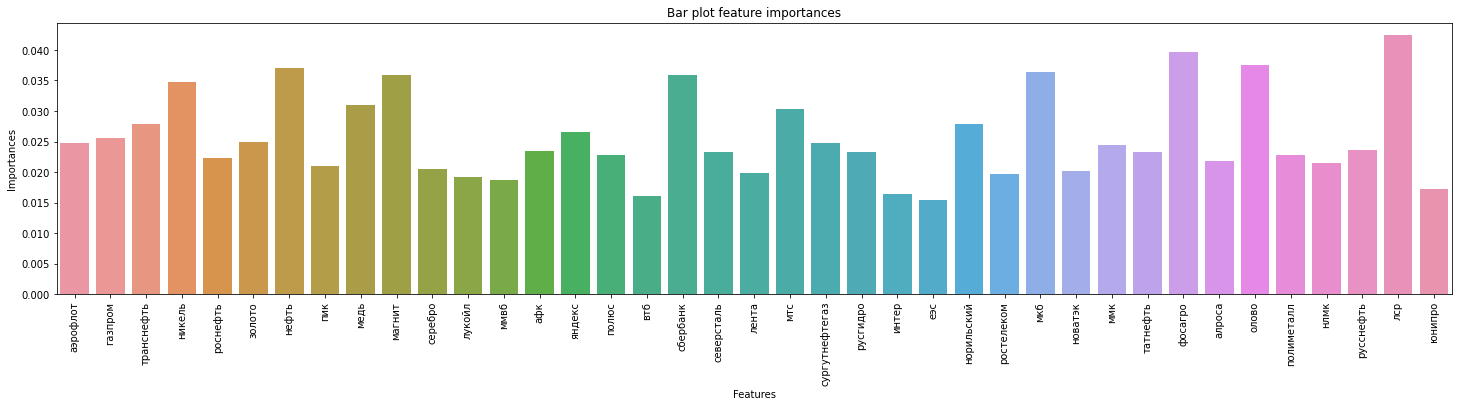

In [71]:
fig, ax = plt.subplots(figsize=(25, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_2d.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Importances');

## Бустинг: AdaBoost. 

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

In [73]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=42),random_state=42,learning_rate=0.01)

model_ada.fit(X_train, y_train)
preds_test = model_ada.predict(X_test)
f1_score(preds_test, y_test)

0.5111111111111111

In [74]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [385]:
model_for_gs = GradientBoostingClassifier()
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
parameters = {
    "learning_rate": 0.1**np.arange(3),
    "max_depth":[1,2,3,4,5,6],
    "n_estimators": [10,50,100,200,300,500,1000]
    }
gs = GridSearchCV(model_for_gs, 
                  parameters, 
                  cv=3, 
                  scoring=make_scorer(f1_score),
                  verbose=5)
 
gs.fit(X_train, y_train)
 
print("Лучшие гиперпараметры:", gs.best_params_)
print("Лучшее значение метрики:", gs.best_score_)

Fitting 3 folds for each of 126 candidates, totalling 378 fits
[CV 1/3] END learning_rate=1.0, max_depth=1, n_estimators=10;, score=0.549 total time=   0.1s
[CV 2/3] END learning_rate=1.0, max_depth=1, n_estimators=10;, score=0.565 total time=   0.1s
[CV 3/3] END learning_rate=1.0, max_depth=1, n_estimators=10;, score=0.540 total time=   0.1s
[CV 1/3] END learning_rate=1.0, max_depth=1, n_estimators=50;, score=0.559 total time=   0.3s
[CV 2/3] END learning_rate=1.0, max_depth=1, n_estimators=50;, score=0.560 total time=   0.2s
[CV 3/3] END learning_rate=1.0, max_depth=1, n_estimators=50;, score=0.477 total time=   0.2s
[CV 1/3] END learning_rate=1.0, max_depth=1, n_estimators=100;, score=0.561 total time=   0.4s
[CV 2/3] END learning_rate=1.0, max_depth=1, n_estimators=100;, score=0.544 total time=   0.4s
[CV 3/3] END learning_rate=1.0, max_depth=1, n_estimators=100;, score=0.508 total time=   0.4s
[CV 1/3] END learning_rate=1.0, max_depth=1, n_estimators=200;, score=0.518 total time= 

In [386]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.010000000000000002, max_depth = 1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.5238095238095238

### Градиентный бустинг: XGBoost

In [76]:
from xgboost import XGBClassifier

In [77]:
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train,y_train)
preds_test = model_xgb.predict(X_test)
f1_score(preds_test, y_test)

0.5191256830601093

### Градиентный бустинг: Catboost

In [78]:
from catboost import CatBoostClassifier

In [79]:
model = CatBoostClassifier(iterations=2000,random_state=42,learning_rate=0.03)
model.fit(X_train, y_train)
preds_class = model.predict(X_test)
f1_score(preds_class, y_test)

0:	learn: 0.6908135	total: 77.1ms	remaining: 2m 34s
1:	learn: 0.6892909	total: 89.3ms	remaining: 1m 29s
2:	learn: 0.6876554	total: 95.8ms	remaining: 1m 3s
3:	learn: 0.6860030	total: 102ms	remaining: 51.1s
4:	learn: 0.6837175	total: 108ms	remaining: 43.2s
5:	learn: 0.6825584	total: 116ms	remaining: 38.4s
6:	learn: 0.6803165	total: 122ms	remaining: 34.8s
7:	learn: 0.6778556	total: 131ms	remaining: 32.6s
8:	learn: 0.6760759	total: 137ms	remaining: 30.3s
9:	learn: 0.6747048	total: 145ms	remaining: 28.9s
10:	learn: 0.6725166	total: 155ms	remaining: 28s
11:	learn: 0.6709149	total: 165ms	remaining: 27.3s
12:	learn: 0.6688942	total: 182ms	remaining: 27.8s
13:	learn: 0.6671659	total: 201ms	remaining: 28.5s
14:	learn: 0.6652934	total: 230ms	remaining: 30.5s
15:	learn: 0.6633635	total: 245ms	remaining: 30.3s
16:	learn: 0.6619977	total: 260ms	remaining: 30.3s
17:	learn: 0.6602453	total: 278ms	remaining: 30.6s
18:	learn: 0.6583951	total: 295ms	remaining: 30.7s
19:	learn: 0.6571019	total: 341ms	rema

0.5365853658536586

Стекинг

In [80]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [421]:
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('knn', KNeighborsClassifier(n_neighbors= 11)),
              ('nb', GaussianNB() )               
]
metamodel = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
metamodel.fit(X_train, y_train)
pred = metamodel.predict(X_test)
f1_score(y_test, pred)

0.6057906458797327

Это лучший показатель на тестовый выборке из всех наших вариантов.

0,52 + 19% =0.61 Получили прирост  19% от baseline.

## 6. Проектируем процесс предсказания

Оценка возможности реализации предложенного решения в продакшене

Алгоритм будет таким: ММВБ начинает торги в 10-00, буду максимально моделировать работу в реалтайме, буду запрашивать новости дня с 00-00 до 10-00 и пропустив через все процессы, что были выше, давать прогноз на движения индекса РТС. Затем буду добавлять тексты каждого след. часа и обновлять прогноз. и так до 18-00 (буду делать ежечастно) итого 9 прогнозов за день и буду смотреть реальное движение индекса в течении дня. Возможно развороты движения индекса будут не совпадать точно по времени, это может зависить и от большого интервала или от возможного интервала задержки движения инндекса, но это тема отдельной дипломной работы. В проекте буду анализировать октябрь 2023.

In [3]:
filters = {
    "gaz": ["газпром", "gaz"],
    "sber": ["сбербанк", "sber"],
    "luk": ['лукойл','lkoh'],
    "gmkn": ['норильский','gmkn'],
    "yandex":['яндекс','yandex'],
    "novatek":['новатэк','nvtk'],
    "tatneft":['татнефть','tatn'],
    "rosneft":['роснефть','rosn'],
    "sngs":['сургутнефтегаз','sngs'],
    "magn":['магнит','mgnt'],
    "x5":['икс5','five'],
    "mts":['мтс','mtss'],
    "poly":['полиметалл','poly'],
    "alrosa":['алроса','alrs'],
    "sever":['северсталь','chmf'],
    "polys":['полюс','plzl'],
    "interrao":['интер','irao'],
    "nlmk":['нлмк','nlmk'],
    "vtb":['втб','vtbr'],
    "moex":['ммвб','moex'],
    "phor":['фосагро','phor'],
    "transneft":['транснефть','trnfp'],
    "mmk":['ммк','magn'],
    "rostel":['ростелеком','rtkm'],
    "rusal":['русал','rual'],
    "aero":['аэрофлот','aflt'],
    "pik":['пик','pikk'],
    "rusgydro":['русгидро','hydr'],
    "fees":['еэс','fees'],
    "afk":['афк','afks'],
    "lsr":['лср','lsrg'],
    "mkb":['мкб','cbom'],
    "unipro":['юнипро','upro'],
    "dsky":['детский мир','dsky'],
    "lnta":['лента','lnta'],
    "russneft":['русснефть','rnft'],
    "mvideo":['Мвидео','mvid'],
    "oil":['нефть','oil'],
    "cupper":['медь','cupper'],
    "nikel":['никель','nikel'],
    "olovo":['олово','tin'],
    "silver":['серебро','silver'],
    "gold":['золото','gold']
}

In [4]:
word_dict=['газпром','gazp','сбербанк','sber','sberp','лукойл','лукоил','lkoh','норильский','gmkn',
           'яндекс','yandex','yndx','новатэк','nvtk','татнефт','tatn','роснефт','rosn','сергутнефтегаз','sngs',
           'магнит','mgnt','икс5','x5','five','мтс','mtss','полиметалл','poly','алрос','alrs','северстал','chmf',
           'полюс','plzl','интер','irao','нлмк','nlmk','втб','vtbr','moex','фосагро','phor','транснефт','trnfp', 
           'ммк','magn','ростелеком','rtkm','русал','rual','аэрофлот','aflt','пик','pikk','русгидро','hydr',
           'еэс','fees','афк','afks','лср','lsrg','cbom','юнипро','upro','dsky','lnta','sfin',
           'русснефт','rnft','Мвидео','mvid','нефт',' медь',' меди','cupper','никел','nikel','олово','tin','серебро','silver','золото','gold']

In [5]:
#зададим интервалы опроса
time_for_production = ['10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00']


In [53]:
import datetime as DT

start_date = DT.datetime(2023, 10, 1)
end_date = DT.datetime(2023, 10, 31)

res = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date))

Удалю выходные

In [54]:
new_list = []
for i in range(len(res)):
    if (not res[i].weekday() == 5) and (not (res[i].weekday() == 6)):
        new_list.append(res[i])
new_list

[Timestamp('2023-10-02 00:00:00'),
 Timestamp('2023-10-03 00:00:00'),
 Timestamp('2023-10-04 00:00:00'),
 Timestamp('2023-10-05 00:00:00'),
 Timestamp('2023-10-06 00:00:00'),
 Timestamp('2023-10-09 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-11 00:00:00'),
 Timestamp('2023-10-12 00:00:00'),
 Timestamp('2023-10-13 00:00:00'),
 Timestamp('2023-10-16 00:00:00'),
 Timestamp('2023-10-17 00:00:00'),
 Timestamp('2023-10-18 00:00:00'),
 Timestamp('2023-10-19 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-10-23 00:00:00'),
 Timestamp('2023-10-24 00:00:00'),
 Timestamp('2023-10-25 00:00:00'),
 Timestamp('2023-10-26 00:00:00'),
 Timestamp('2023-10-27 00:00:00'),
 Timestamp('2023-10-30 00:00:00'),
 Timestamp('2023-10-31 00:00:00')]

In [55]:
new_list= pd.to_datetime(new_list, format='%Y-%m-%d')

In [473]:
#Соединяемся с БД
connection = create_connection("localhost","ev","ev")

Подключение к базе данных прошло успешно


In [58]:
new_list_str = new_list.strftime('%Y-%m-%d')

In [50]:
dict_values_prod=defaultdict(list) 
new_dict_prod={} #создаем пустой словарь
ton_day = pd.DataFrame()
ton_part_of_day= pd.DataFrame()

#ton_day = pd.DataFrame.from_dict(dict_values_prod, orient='index')
#ton_part_of_day = pd.DataFrame.from_dict(dict_values_prod, orient='index')


In [49]:
def convert_text_prod(text):
    elem = list(filters.keys())#заберем ключи из словаря
    message=[text]
    for i in elem: # меняем все английские упоминания компаний на русский язык
        text.replace(filters[i][1], filters[i][0]) #потому что лемматизация уберет все англ. слова
    word_list=lemmatize(text) #разбиваем текст на массив слов в нормальной форме
    if word_list:
        for j in elem:
            if filters[j][0] in word_list:
                sentiment2 = model.predict(message, k = 5) #проводим анализ тональности
                dict_values_prod[filters[j][0]].append(sentiment2[0]['positive'])#заполняем словарь
    for key in dict_values_prod:
        new_dict_prod[key]=mean(dict_values_prod[key]) #получаем среднее значение

Чтобы анализ в течение дня был максимально быстрым, то можно разбить его на первую основную часть и дополнительные. Основная часть это все новости до старта торгов, т.е. до 10-00.
Дополнительные это последующие интервалы, которые будут корректировать итоговую тональность дня. Можно этот интервал брать любым, я возьму час.

In [48]:
def analiz_prod(_texts,start_flag):
    
    global new_dict_prod,ton_day,ton_part_of_day,median_value2,X_train
    _texts = _texts.drop_duplicates (subset=['text'])
    for i in range(len(_texts)):
        convert_text_prod(_texts['text'].iloc[i])
    for key in dict_values_prod:
        #print ("%s -> %s" % (key, mean(dict_values[key])))
        new_dict_prod[key]=mean(dict_values_prod[key])
    if start_flag:
        ton_day_temp = pd.DataFrame.from_dict(new_dict_prod, orient='index')
        ton_day_temp=ton_day_temp.T
        #print('startday',ton_day_temp)
        global ton_day
        ton_day=ton_day_temp
    else:
        ton_part_of_day_temp = pd.DataFrame.from_dict(new_dict_prod, orient='index')
        ton_part_of_day_temp=ton_part_of_day_temp.T
        #print('dop_news',ton_part_of_day_temp)
        global ton_part_of_day
        ton_part_of_day=ton_part_of_day_temp


Стартовый блок новостей

In [501]:
def start_of_day(_date):
    query = f'''select id, text, time, source_id 
                from NEWS_DATA.`{_date}`
                WHERE MATCH(text) AGAINST(' '''
    query += ' '.join(where2) 
    query_time = f''' AND (time > "00:00:00" AND time < "10:00:00");'''
    query = query + "' IN BOOLEAN MODE)" + query_time #формируем итоговый запрос
    df_start_product = pd.read_sql_query(query, connection) #отправляем запрос
    #print(df_start_product)
    global new_dict_prod,ton_day,ton_part_of_day,median_value2
    new_dict_prod={} #создаем пустой словарь
    ton_day = pd.DataFrame()
    ton_part_of_day= pd.DataFrame()
    analiz_prod(df_start_product,1)
    for i in list(median_value2):
        if not i in ton_day.columns :
            #print( median_value2[i].values)
            ton_day[i] = median_value2[i].values
    new_df = pd.concat([X_train.iloc [[0]], ton_day])
    print('start_day:',_date,metamodel.predict(new_df.iloc [[1]]))
    

In [493]:
median_value2

,аэрофлот,газпром,транснефть,никель,роснефть,золото,нефть,пик,медь,магнит,...,ммк,татнефть,фосагро,алроса,олово,полиметалл,нлмк,русснефть,лср,юнипро
0,0.064861,0.050164,0.056533,0.07007,0.063112,0.092288,0.062581,0.080228,0.071836,0.069429,...,0.064816,0.059004,0.059126,0.056113,0.068817,0.06529,0.06253,0.061223,0.064819,0.051855


In [343]:

#analiz_prod(df_start_product,1)

startday      интер    золото       пик      медь    яндекс   газпром       втб  \
0  0.08877  0.123605  0.088334  0.072355  0.058498  0.049389  0.069921   

    фосагро      ммк   серебро  ...  роснефть    алроса       еэс  северсталь  \
0  0.065371  0.06521  0.090628  ...  0.065615  0.055829  0.075868     0.06632   

      лента  сургутнефтегаз       афк     олово    никель  транснефть  
0  0.071448        0.055886  0.048152  0.125994  0.046302    0.037396  

[1 rows x 34 columns]


In [46]:
median_value2=median_value.to_frame(name='0')

In [47]:
median_value2 = median_value2.T

In [345]:
for i in list(median_value2):
    if not i in ton_day.columns :
        print( median_value2[i].values)
        ton_day[i] = median_value2[i].values

[0.06303659]
[0.06528951]
[0.06122344]
[0.06481939]
[0.05185546]


In [406]:
new_df = pd.concat([X_train.iloc [[0]], ton_day])

In [504]:
def continue_of_day(_date):
        for i in range(len(time_for_production)-1): 
                query = f'''select id, text, time, source_id 
                from NEWS_DATA.`{_date}`
                WHERE MATCH(text) AGAINST(' '''
                query += ' '.join(where2) 
                query_time = f''' AND (time > "{time_for_production[i]}" AND time < "{time_for_production[i+1]}");'''
                query = query + "' IN BOOLEAN MODE)" + query_time #формируем итоговый запрос
                df_temp_product = pd.read_sql_query(query, connection) #отправляем запрос
                #print(df_temp_product)
                analiz_prod(df_temp_product,0)
                #print(new_dict_prod)
                global new_dict_prod,ton_day,ton_part_of_day,median_value2,X_train
                #print('ton_day1',ton_day)
                
                ton_day = pd.concat([ton_day, ton_part_of_day])
                #print('ton_day2',ton_day)
                ton_day = ton_day.mean()
                #print('ton_day3',ton_day)
                ton_day = (ton_day.to_frame()).T
                new_df = pd.concat([X_train.iloc [[0]], ton_day])
                #print('Xtrain',X_train.iloc [[0]])
                #print('ton_day4',ton_day)
                #print('new_df',new_df)
                print('predict time:',time_for_production[i+1], metamodel.predict(new_df.iloc [[1]]))

In [505]:
for i in range(len(new_list_str)):
    start_of_day(new_list_str[i])
    continue_of_day(new_list_str[i])

start_day: 2023-10-02 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-03 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-04 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-05 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-06 [1]
predic

Сложно анализировать такие результаты. :)

Предсказание только вверх. Но всё таки сделаю вывод:
![Индекс РТС Октябрь 2023](Rts_oct.jpg)

Если бы мы купили фьючерс РТС 2 Октября в 10-00, к концу октября наш доход составил бы 7.3% :)
В целом биржевой рынок очень инерционный, когда нет каких-то фундаметальных событий. Поэтому необходимо больше наблюдений. Я продолжу анализировать прогнозы от выбранной модели. Но очень интересно когда модель будет говорить вниз.

А теперь бонусный модуль, пока вносил последнии правки для отправки на проверку, решил таки проверить еще одну модель(Бэггинг: случайный лес. ) на трейниговой части она показала очень хорошие результаты и надеюсь на прогнозы отличные от 1. ))

In [44]:
def start_of_day(_date):
    query = f'''select id, text, time, source_id 
                from NEWS_DATA.`{_date}`
                WHERE MATCH(text) AGAINST(' '''
    query += ' '.join(where2) 
    query_time = f''' AND (time > "00:00:00" AND time < "10:00:00");'''
    query = query + "' IN BOOLEAN MODE)" + query_time #формируем итоговый запрос
    df_start_product = pd.read_sql_query(query, connection) #отправляем запрос
    #print(df_start_product)
    global new_dict_prod,ton_day,ton_part_of_day,median_value2
    new_dict_prod={} #создаем пустой словарь
    ton_day = pd.DataFrame()
    ton_part_of_day= pd.DataFrame()
    analiz_prod(df_start_product,1)
    for i in list(median_value2):
        if not i in ton_day.columns :
            #print( median_value2[i].values)
            ton_day[i] = median_value2[i].values
    new_df = pd.concat([X_train.iloc [[0]], ton_day])
    print('start_day:',_date,rf_clf_2d.predict(new_df.iloc [[1]]))

In [45]:
def continue_of_day(_date):
        for i in range(len(time_for_production)-1): 
                query = f'''select id, text, time, source_id 
                from NEWS_DATA.`{_date}`
                WHERE MATCH(text) AGAINST(' '''
                query += ' '.join(where2) 
                query_time = f''' AND (time > "{time_for_production[i]}" AND time < "{time_for_production[i+1]}");'''
                query = query + "' IN BOOLEAN MODE)" + query_time #формируем итоговый запрос
                df_temp_product = pd.read_sql_query(query, connection) #отправляем запрос
                #print(df_temp_product)
                analiz_prod(df_temp_product,0)
                #print(new_dict_prod)
                global new_dict_prod,ton_day,ton_part_of_day,median_value2,X_train
                #print('ton_day1',ton_day)
                
                ton_day = pd.concat([ton_day, ton_part_of_day])
                #print('ton_day2',ton_day)
                ton_day = ton_day.mean()
                #print('ton_day3',ton_day)
                ton_day = (ton_day.to_frame()).T
                new_df = pd.concat([X_train.iloc [[0]], ton_day])
                #print('Xtrain',X_train.iloc [[0]])
                #print('ton_day4',ton_day)
                #print('new_df',new_df)
                print('predict time:',time_for_production[i+1], rf_clf_2d.predict(new_df.iloc [[1]]))

In [66]:
for i in range(len(new_list_str)):
    start_of_day(new_list_str[i])
    continue_of_day(new_list_str[i])

start_day: 2023-10-02 [0]
predict time: 11:00:00 [0]
predict time: 12:00:00 [0]
predict time: 13:00:00 [0]
predict time: 14:00:00 [0]
predict time: 15:00:00 [0]
predict time: 16:00:00 [0]
predict time: 17:00:00 [0]
predict time: 18:00:00 [0]
start_day: 2023-10-03 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-04 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-05 [1]
predict time: 11:00:00 [1]
predict time: 12:00:00 [1]
predict time: 13:00:00 [1]
predict time: 14:00:00 [1]
predict time: 15:00:00 [1]
predict time: 16:00:00 [1]
predict time: 17:00:00 [1]
predict time: 18:00:00 [1]
start_day: 2023-10-06 [1]
predic

![Индекс РТС Октябрь 2023](Rts2_oct.jpg)

Расчитаем прибыль по второму варианту.

In [69]:
#я подготовил файл с точками смены позиции.
rtsi_oct = pd.read_csv(f'rts2.csv',delimiter=';')

In [70]:
rtsi_oct

,<DATE>,<TIME>,<OPEN>,<CLOSE>,position
0,231002,100000,"1006,14","1011,71",short
1,231003,100000,"991,44","985,98",long
2,231023,100000,"1081,74","1082,48",short
3,231023,130000,"1085,32","1084,21",long
4,231023,150000,"1085,64","1084,14",short
5,231023,170000,"1084,25","1086,77",long
6,231031,180000,"1076,73","1079,88",long


In [76]:
rtsi_oct['position'].iloc[0]

'short'

In [82]:
rtsi_oct['<CLOSE>'] = rtsi_oct['<CLOSE>'].str.replace(',', '.')
rtsi_oct['<CLOSE>'] = rtsi_oct['<CLOSE>'].astype(float)
rtsi_oct['<OPEN>'] = rtsi_oct['<OPEN>'].str.replace(',', '.')
rtsi_oct['<OPEN>'] = rtsi_oct['<OPEN>'].astype(float)

In [83]:
rtsi_oct['<OPEN>']=rtsi_oct['<OPEN>'].astype(float)
rtsi_oct['<CLOSE>']=rtsi_oct['<CLOSE>'].astype(float)


In [85]:
delta_boost = 0
for i in range(len(rtsi_oct)-1):
    if rtsi_oct['position'].iloc[i] == 'short':
        delta_boost=delta_boost + (100 - (rtsi_oct['<OPEN>'].iloc[i+1] * 100) / (rtsi_oct['<OPEN>'].iloc[i]))
    else:
        delta_boost=delta_boost + ((rtsi_oct['<OPEN>'].iloc[i+1] * 100) / (rtsi_oct['<OPEN>'].iloc[i])-100)
print('delta_boost:=',delta_boost)

delta_boost:= 9.70199765252373


+ +2.6 % к модели Сттекинга. Но  целом выборка крайне маленькая, буду продолжать наблюдения уже вне диплома.

Список используемой литературы:
1) Морфологический анализатор pymorphy2 https://pymorphy2.readthedocs.io/en/stable/
2) Sentiment analysis library for russian language. https://pypi.org/project/dostoevsky/